In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Temperatura média mensal de Bangladesh entre os anos de 1901 e 2019

In [373]:
df = pd.read_csv("1901_2019_BD_weather.csv")
df

,Year,Month,Temperature,Rain
0,1901,1,16.98,18.54
1,1901,2,19.90,16.25
2,1901,3,24.32,70.80
3,1901,4,28.18,66.16
4,1901,5,27.89,267.22
...,...,...,...,...
1423,2019,8,29.00,407.13
1424,2019,9,28.28,366.79
1425,2019,10,26.94,230.03
1426,2019,11,23.88,20.01


In [374]:
df['Data'] = df['Month'].astype(str).str.zfill(2) + '/' + df['Year'].astype(str)

In [375]:
df['Data'] = df['Data'].astype(str)
df['Data'] = pd.to_datetime(df['Data'], format='%m/%Y')
df['Data'] = df['Data'].dt.strftime('%m/%Y')
df.set_index(pd.to_datetime(df['Data']), inplace=True)
df.head()

,Year,Month,Temperature,Rain,Data
Data,,,,,
1901-01-01,1901,1,16.98,18.54,01/1901
1901-02-01,1901,2,19.90,16.25,02/1901
1901-03-01,1901,3,24.32,70.80,03/1901
1901-04-01,1901,4,28.18,66.16,04/1901
1901-05-01,1901,5,27.89,267.22,05/1901


In [376]:
df = df.drop(['Rain', 'Month', 'Year', 'Data'], axis=1)

In [377]:
df.rename(columns={'Temperature ': 'Temperatura'}, inplace=True)

In [378]:
df.shape

(1428, 1)

In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1428 entries, 1901-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  1428 non-null   float64
dtypes: float64(1)
memory usage: 22.3 KB


In [380]:
df.describe()

,Temperatura
count,1428.000000
mean,25.078908
std,3.682308
min,16.800000
25%,22.120000
50%,27.015000
75%,28.030000
max,29.530000


## **Exibição gráfica dos dados**

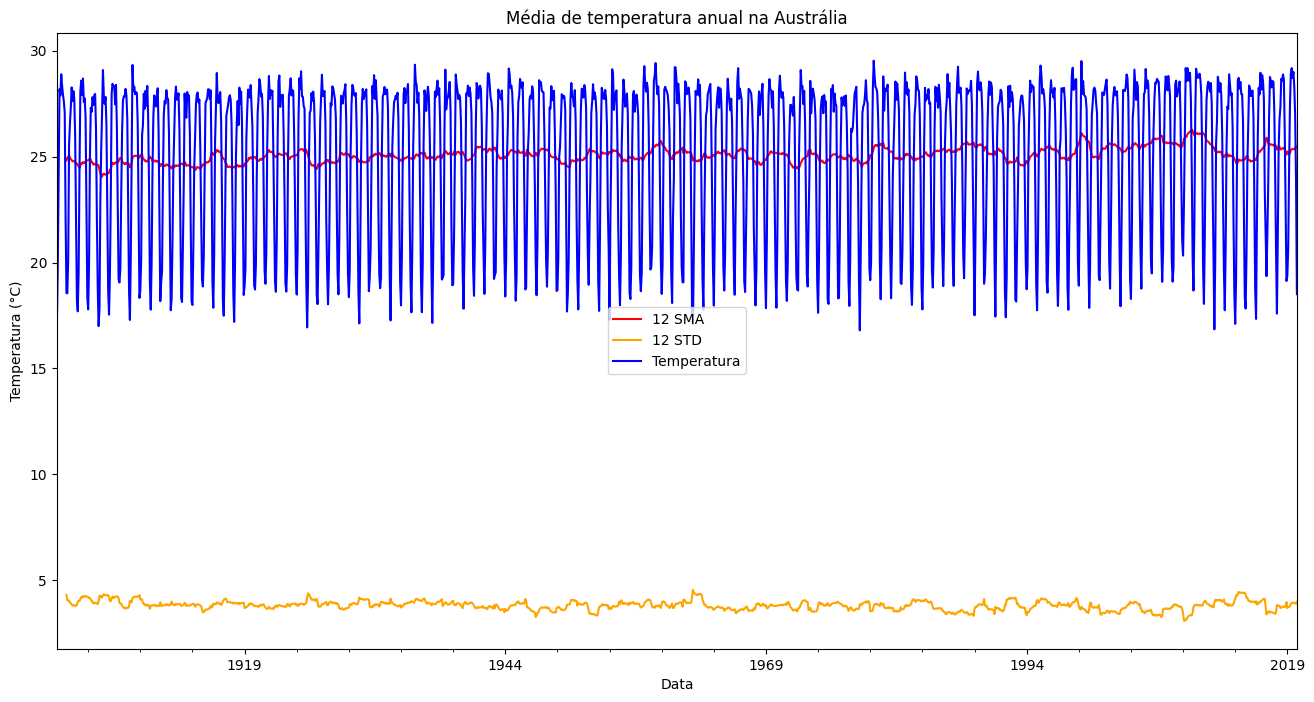

In [381]:
df['Temperatura'].rolling(12).mean().plot(label = '12 SMA',figsize = (16,8), color='red')
df['Temperatura'].rolling(12) .std().plot(label = '12 STD', color='orange')
df['Temperatura'].plot(color='blue')

# df['Temperatura'].plot(figsize=(15, 8))
plt.title('Média de temperatura anual na Austrália')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

## **Decomposição dos dados da série temporal**

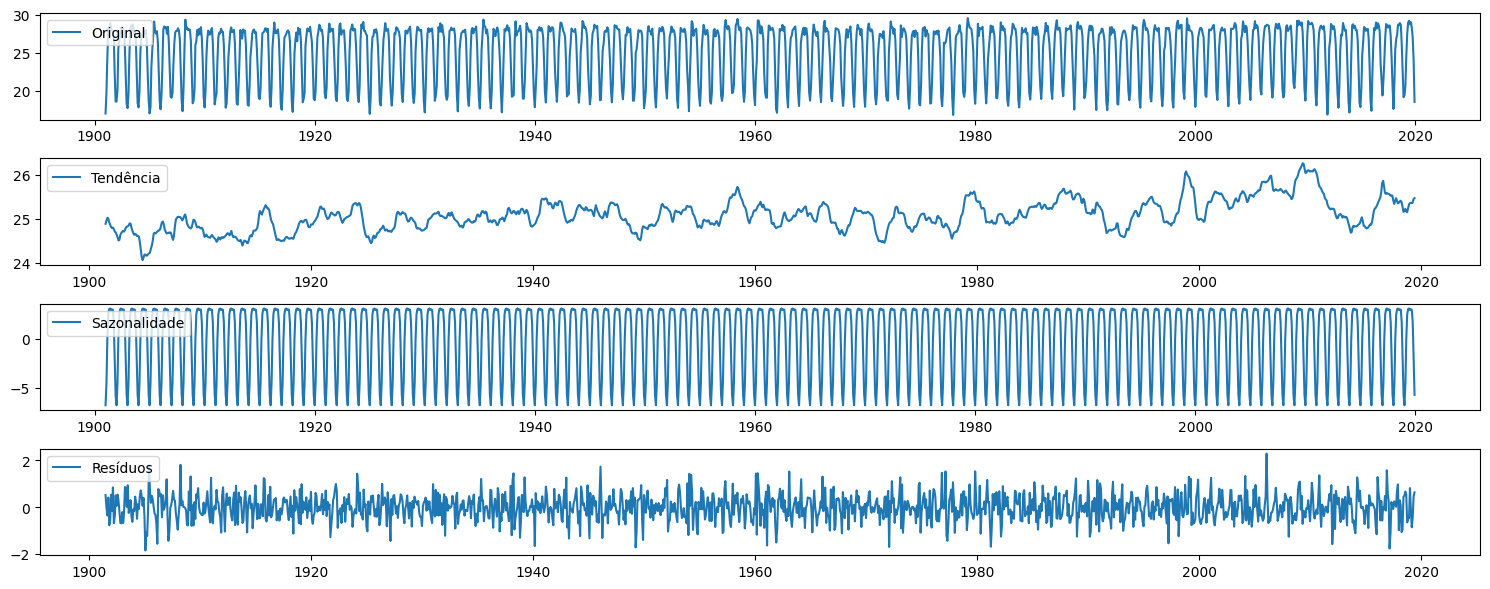

In [382]:
decomp = seasonal_decompose(df['Temperatura'], period=12)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15, 6))

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Resíduos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [383]:
def teste_estacionariedade(data):
    fuller_test = adfuller(data)
    print("Estatística do teste:", fuller_test[0])
    print('P-value: ',fuller_test[1])

    if fuller_test[1] <= 0.05:
        print('Rejeitar hipótese nula, os dados são estacionários')
    else:
        print('Não rejeitar a hipótese nula, os dados não são estacionários')

teste_estacionariedade(df['Temperatura'])

Estatística do teste: -4.170514759525883
P-value:  0.0007388548034403272
Rejeitar hipótese nula, os dados são estacionários


## **Traçando o gráfico ACF e PACF**

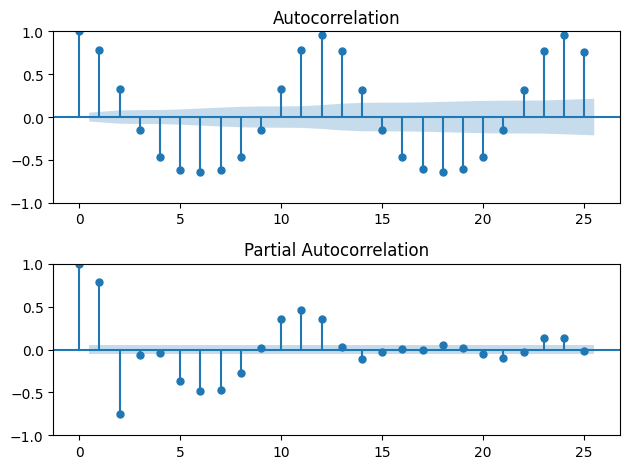

In [384]:
def plot_acf_pacf_graphs(series):
    fig, ax = plt.subplots(2,1)
    fig = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax[1])
    plt.tight_layout()
    plt.show()

plot_acf_pacf_graphs(df)

## **Construção dos modelos**

In [385]:
# Dividir o conjunto de dados em treinamento e teste
train_data = df[:'2010-12-31']
test_data = df['2011-01-01':]

## **ARIMA**

In [386]:
def arima_forecast(train_data, test_data, order=(1, 0, 0)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    return forecast, rmse

## **ETS**

In [387]:
def ets_forecast(train_data, test_data, seasonal='add', seasonal_periods=12):
    model = ExponentialSmoothing(train_data, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    return forecast, rmse

## **Regressão linear**

In [388]:
def linear_regression_forecast(train_data, test_data):
    X_train = np.arange(len(train_data)).reshape(-1, 1)
    y_train = train_data.values
    X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)

    model = LinearRegression()
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    return forecast, rmse

## **LSTM**

In [389]:
def lstm_forecast(train_data, test_data, n_steps=12, n_epochs=100):
    # Preparar os dados em sequências
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data)

    X_train, y_train = [], []
    for i in range(n_steps, len(scaled_data)):
        X_train.append(scaled_data[i - n_steps:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Construir o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')

    # Treinar o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Prever
    inputs = scaled_data[-n_steps:]
    forecast = []
    for i in range(len(test_data)):
        X_test = inputs[-n_steps:].reshape(1, n_steps, 1)
        y_pred = model.predict(X_test)
        forecast.append(y_pred[0][0])
        inputs = np.append(inputs, y_pred)[1:]

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    return forecast, rmse

## **Avaliação dos modelos**

In [390]:
def evaluate_models(train_data, test_data, arima_order=(1, 1, 1), ets_seasonal='add', ets_seasonal_periods=12, lstm_params={}):
    # Avaliar o modelo ARIMA
    arima_forecast_result, arima_rmse = arima_forecast(train_data, test_data, order=arima_order)

    # Avaliar o modelo ETS
    ets_forecast_result, ets_rmse = ets_forecast(train_data, test_data, seasonal=ets_seasonal, seasonal_periods=ets_seasonal_periods)

    # Avaliar o modelo de Regressão Linear
    linear_regression_forecast_result, linear_regression_rmse = linear_regression_forecast(train_data, test_data)

    # Avaliar o modelo LSTM
    lstm_forecast_result, lstm_rmse = lstm_forecast(train_data, test_data, **lstm_params)

    print(f'ARIMA RMSE: {arima_rmse:.2f}')
    print(f'ETS RMSE: {ets_rmse:.2f}')
    print(f'Regressão Linear RMSE: {linear_regression_rmse:.2f}')
    print(f'LSTM RMSE: {lstm_rmse:.2f}')

# Uso da função
lstm_params = {
    'n_steps': 12,  # Número de passos no tempo para prever o próximo ponto
    'n_epochs': 100  # Número de épocas para treinar o modelo LSTM
}

evaluate_models(train_data, test_data, arima_order=(1, 1, 1), ets_seasonal='add', ets_seasonal_periods=12, lstm_params=lstm_params)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1/1 [==============================] - 0s 32ms/step
ARIMA RMSE: 11.46
ETS RMSE: 1.09
Regressão Linear RMSE: 3.80
LSTM RMSE: 0.82


## **Gráficos de previsões**

<ipython-input-391-6b668da8cfc0>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


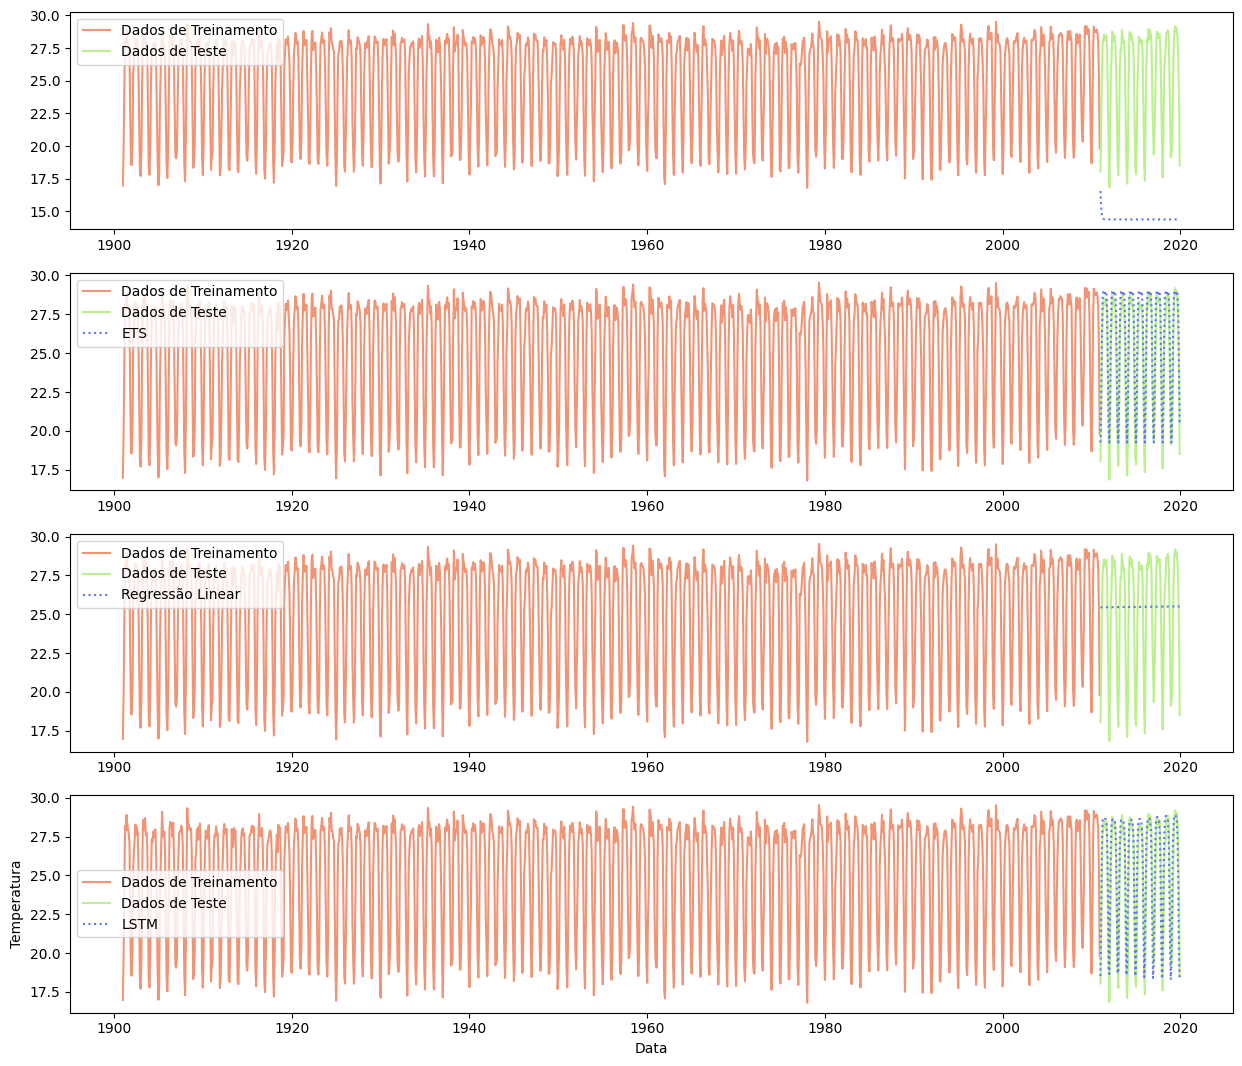

In [391]:
def plot_forecasts(train_data, test_data, arima_forecast_result, ets_forecast_result,
                   linear_regression_forecast_result, lstm_forecast_result, title='Previsões de Temperatura'):

    plt.figure(figsize=(15, 13))
    plt.title(title)

    #Dados de treinamento
    plt.subplot(411)
    plt.plot(train_data.index, train_data['Temperatura'], label='Dados de Treinamento', color='#F09475')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(train_data.index, train_data['Temperatura'], label='Dados de Treinamento', color='#F09475')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(train_data.index, train_data['Temperatura'], label='Dados de Treinamento', color='#F09475')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(train_data.index, train_data['Temperatura'], label='Dados de Treinamento', color='#F09475')
    plt.legend(loc='upper left')

    # Dados de teste
    plt.subplot(411)
    plt.plot(test_data.index, test_data['Temperatura'], label='Dados de Teste', color='#BAF08D')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(test_data.index, test_data['Temperatura'], label='Dados de Teste', color='#BAF08D')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(test_data.index, test_data['Temperatura'], label='Dados de Teste', color='#BAF08D')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(test_data.index, test_data['Temperatura'], label='Dados de Teste', color='#BAF08D')
    plt.legend(loc='upper left')

    # Previsões dos modelos
    plt.subplot(411)
    plt.plot(test_data.index, arima_forecast_result, label='ARIMA', linestyle=':', color='#5D75F0')

    plt.subplot(412)
    plt.plot(test_data.index, ets_forecast_result, label='ETS', linestyle=':', color='#5D75F0')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(test_data.index, linear_regression_forecast_result, label='Regressão Linear', linestyle=':', color='#5D75F0')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(test_data.index, lstm_forecast_result, label='LSTM', linestyle=':', color='#5D75F0')
    plt.legend(loc='upper left')

    # plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Temperatura')
    plt.legend()
    # plt.grid(True)
    plt.show()

# Uso da função para plotar os gráficos
plot_forecasts(train_data, test_data, arima_forecast_result, ets_forecast_result,
               linear_regression_forecast_result, lstm_forecast_result)


## **Gráfico de comparação entre os modelos**

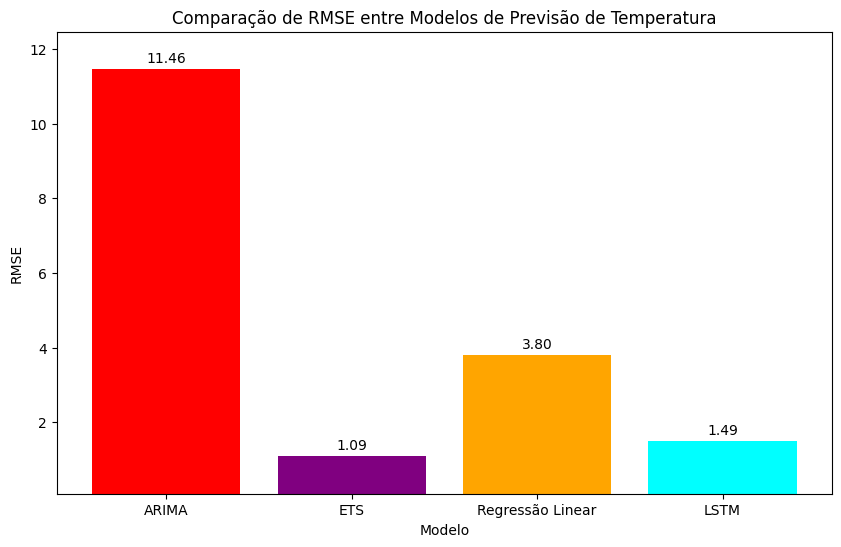

In [392]:
# Resultados RMSE dos modelos
rmse_values = [arima_rmse, ets_rmse, linear_regression_rmse, lstm_rmse]

# Nomes dos modelos
model_names = ['ARIMA', 'ETS', 'Regressão Linear', 'LSTM']

# Cores para as barras
colors = ['red', 'purple', 'orange', 'cyan']

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color=colors)
plt.title('Comparação de RMSE entre Modelos de Previsão de Temperatura')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.ylim(min(rmse_values) - 1, max(rmse_values) + 1)

# Adicionar valores acima das barras
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()
